# Problem 5

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("Data/penguins.csv").dropna()
df.head(5)

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


## Part A

In [3]:
species = ['Adelie', 'Chinstrap', 'Gentoo']
cols = df.columns
groups = [df[df[cols[0]]==specie] for specie in species]

In [4]:
def scatterPlot(ax, x, y):
    for i in range(len(groups)):
        ax.scatter(groups[i][cols[x]], groups[i][cols[y]])

    ax.set_xlabel(cols[x])
    ax.set_ylabel(cols[y])

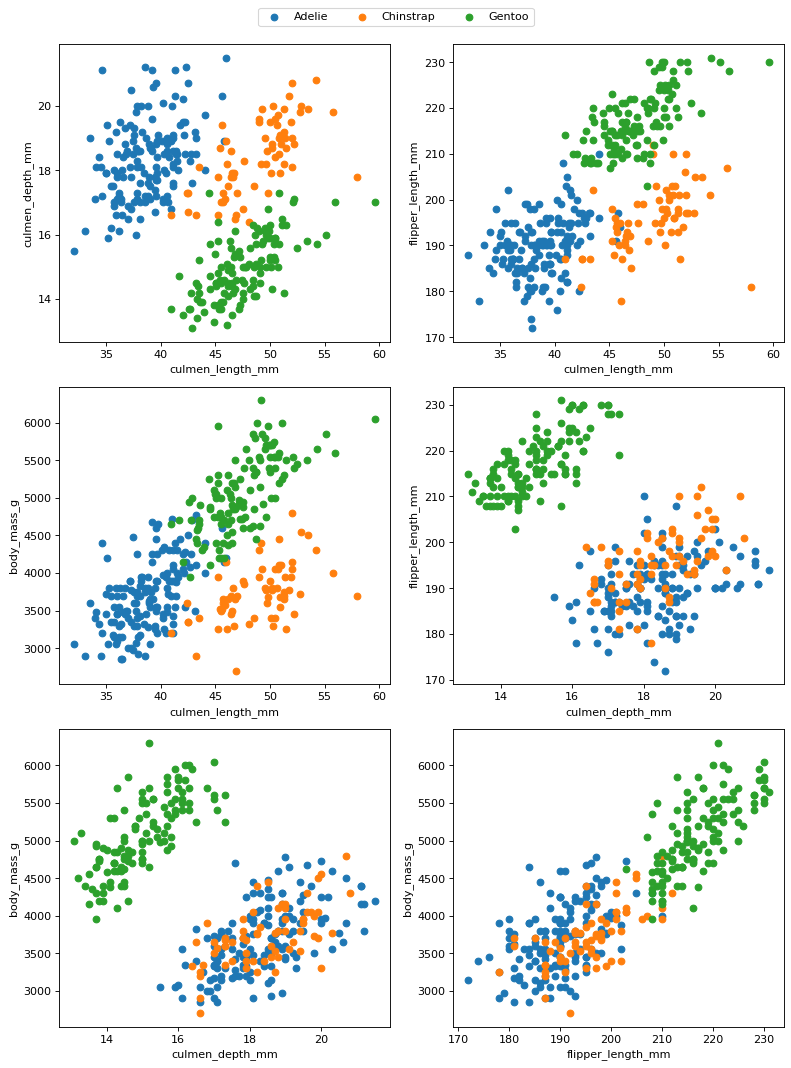

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(10, 13), dpi=80)

i = 0
for x in range(1, 4):
    for y in range(x+1, 5):
        scatterPlot(axs[i//2, i%2], x, y)
        i += 1

fig.legend(species, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
fig.tight_layout()

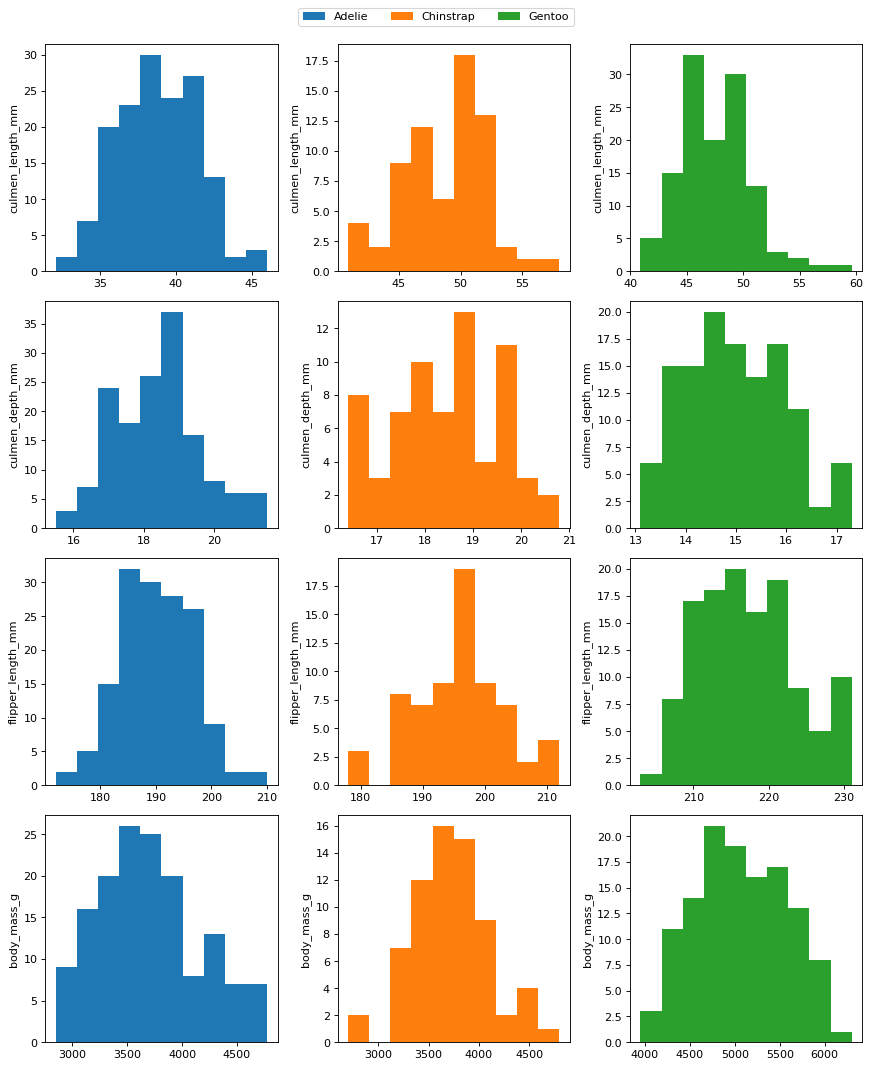

In [6]:
fig, axs = plt.subplots(4, 3, figsize=(11, 13), dpi=80)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i in range(4):
    for j in range(3):
        axs[i, j].hist(groups[j][cols[i+1]], color=colors[j])
        axs[i, j].set_ylabel(cols[i+1])

fig.legend(species, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
fig.tight_layout()

## Part B

### training framework

In [7]:
class MyLogisticRegression:

    def __init__(self):
        self.w = None
        self.b = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def gradient(self, X, yp, y):
        m = X.shape[0]
        dw = np.dot(X.T, (yp - y)) / m
        db = np.sum(yp - y) / m
        return dw, db

    def fit(self, X, y, epochs=1000, learning_rate=1):

        y = y.reshape(y.shape[0], 1)
        w = np.zeros((X.shape[1], 1))
        b = 0

        for epoch in range(epochs):
            yp = self.sigmoid(np.dot(X, w) + b)
            dw, db = self.gradient(X, yp, y)

            w -= learning_rate * dw
            b -= learning_rate * db

        self.w = w
        self.b = b

    def predict(self, X):
        proba = self.sigmoid(np.dot(X, self.w) + self.b)
        return proba

In [8]:
def trainFramework(X_train, y_train, labels):

    classifiers = []

    for label in labels:
        yl = (y_train==label).astype(np.float64)
        myClassifier = MyLogisticRegression()
        myClassifier.fit(X_train, yl)
        classifiers.append(myClassifier)

    return classifiers

In [9]:
def predictFramework(X, classifiers):
    classCount = len(classifiers)
    probs = [None]*classCount
    for i in range(classCount):
        probs[i] = classifiers[i].predict(X)

    probs = np.array(probs).reshape(classCount, X.shape[0]).T
    return np.argmax(probs, axis=1).astype(np.int32)

In [10]:
def my_train_test_split(X, y, test_size):
    test_mask = np.random.rand(X.shape[0]) < test_size
    X_test = X[test_mask]
    y_test = y[test_mask]

    train_mask = ~test_mask
    X_train = X[train_mask]
    y_train = y[train_mask]

    return X_train, X_test, y_train, y_test

### custom test utils

In [11]:
def calc_confusion_matrix(y, yp, m):
    confusionMatrix = np.zeros((m, m)).astype(np.int32)
    for i in range(len(y)):
        confusionMatrix[y[i], yp[i]] += 1

    return confusionMatrix

In [12]:
def draw_confusion_matrix(matrix):
    green = (30, 200, 40, 160)
    red = (255, 25, 0, 140)

    x = matrix.shape[1]
    y = matrix.shape[0]

    colors = [[green if i==j else red for i in range(x)] for j in range(y)]
    colors = np.array(colors).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
    ax.imshow(colors)

    ax.set_xticks(np.arange(x), labels=range(x))
    ax.set_yticks(np.arange(y), labels=range(y))
    
    ax.set_xticks(np.arange(-.5, x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, y, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_xlabel("prediction")
    ax.set_ylabel("label")

    for i in range(y):
        for j in range(x):
            text = ax.text(j, i, matrix[i][j], ha="center", va="center", color='black')

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

In [13]:
def calc_accuracy(cMat):
    return cMat.diagonal().sum() / np.sum(cMat)

def calc_precision(cMat):
    return cMat.diagonal() / np.sum(cMat, axis=0).reshape(cMat.shape[1])

def calc_recall(cMat):
    return cMat.diagonal() / np.sum(cMat, axis=1).reshape(cMat.shape[1])

def calc_jaccard_score(cMat):
    tmp = (cMat.sum(axis=0) + cMat.sum(axis=1) - cMat.diagonal())
    return np.average(cMat.diagonal() / tmp)

def calc_f1_score(precision, recall):
    return 2 * precision * recall / (precision+recall)

In [14]:
def testFramework(y, yp, labels):
    cMat = calc_confusion_matrix(y, yp, len(labels))
    print("accuracy: {:.1f} %".format(calc_accuracy(cMat)*100))

    jaccardScore = calc_jaccard_score(cMat)
    print("Jaccard score: {:.1f} %".format(jaccardScore*100))

    precisions = calc_precision(cMat)
    recalls = calc_recall(cMat)
    f1_scores = calc_f1_score(precisions, recalls)

    separator = '\n' + '-'*40

    for i in range(len(labels)):
        print(separator)
        print('- class "{}" metrics:\n'.format(labels[i]))
        print("\tprecision : {:.1f} %".format(precisions[i]*100))
        print("\trecall    : {:.1f} %".format(recalls[i]*100))
        print("\tf1_score  : {:.1f} %".format(f1_scores[i]*100))

    return cMat

### model training

In [15]:
X = df[cols[1:]].to_numpy().astype(np.float64)
X = (X-X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0))

y = df[cols[0]].apply(lambda x: species.index(x)).to_numpy().astype(np.int32)
labels = np.unique(y)

X_train, X_test, y_train, y_test = my_train_test_split(X, y, 0.25)

In [16]:
myClassifiers = trainFramework(X_train, y_train, labels)
yp = predictFramework(X_test, myClassifiers)
cMat = testFramework(yp, y_test, species)

accuracy: 98.0 %
Jaccard score: 94.9 %

----------------------------------------
- class "Adelie" metrics:

	precision : 100.0 %
	recall    : 95.3 %
	f1_score  : 97.6 %

----------------------------------------
- class "Chinstrap" metrics:

	precision : 89.5 %
	recall    : 100.0 %
	f1_score  : 94.4 %

----------------------------------------
- class "Gentoo" metrics:

	precision : 100.0 %
	recall    : 100.0 %
	f1_score  : 100.0 %


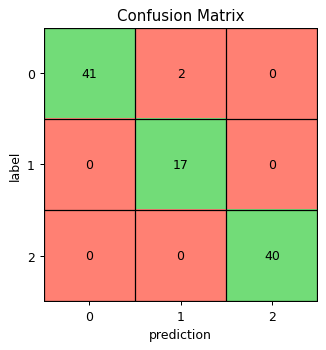

In [17]:
draw_confusion_matrix(cMat)

## Part C

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
skClassifier = LogisticRegression()
skClassifier.fit(X_train, y_train)
yp = skClassifier.predict(X_test)

In [20]:
def testSklearn(y, yp, labels):

    cMat = metrics.confusion_matrix(y_test, yp)
    accuracy = metrics.accuracy_score(y_test, yp)
    jaccardScore = metrics.jaccard_score(y_test, yp, average='macro')
    precisions = metrics.precision_score(y_test, yp, average=None)
    recalls = metrics.recall_score(y_test, yp, average=None)
    f1_scores = metrics.f1_score(y_test, yp, average=None)

    print("accuracy: {:.1f} %".format(accuracy*100))
    print("Jaccard score: {:.1f} %".format(jaccardScore*100))

    separator = '\n' + '-'*40

    for i in range(len(labels)):
        print(separator)
        print('- class "{}" metrics:\n'.format(labels[i]))
        print("\tprecision : {:.1f} %".format(precisions[i]*100))
        print("\trecall    : {:.1f} %".format(recalls[i]*100))
        print("\tf1_score  : {:.1f} %".format(f1_scores[i]*100))
    
    return cMat

In [21]:
cMat = testSklearn(y_test, yp, species)

accuracy: 97.7 %
Jaccard score: 94.7 %

----------------------------------------
- class "Adelie" metrics:

	precision : 94.6 %
	recall    : 100.0 %
	f1_score  : 97.2 %

----------------------------------------
- class "Chinstrap" metrics:

	precision : 100.0 %
	recall    : 89.5 %
	f1_score  : 94.4 %

----------------------------------------
- class "Gentoo" metrics:

	precision : 100.0 %
	recall    : 100.0 %
	f1_score  : 100.0 %


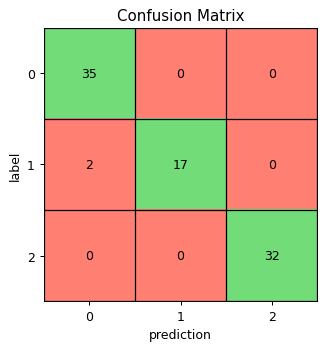

In [22]:
draw_confusion_matrix(cMat)

### ROC curve

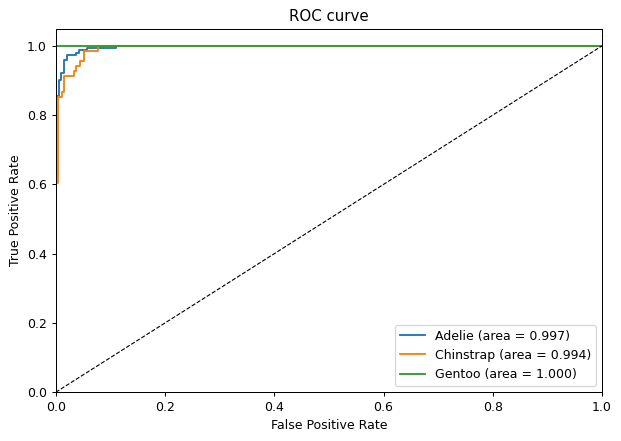

In [23]:
y_score = skClassifier.decision_function(X)
fig, ax = plt.subplots(figsize=(7, 5), dpi=90)

for i in labels:
    fpr, tpr, _ = metrics.roc_curve(y==i, y_score.T[i])
    auc = metrics.auc(fpr, tpr)
    label = "{} (area = {:.3f})".format(species[i], auc)
    ax.plot(fpr, tpr, label=label)

ax.plot([0, 1], [0, 1], color="black", lw=0.9, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curve")
ax.legend(loc="lower right")
fig.tight_layout()
plt.show()